# Combined network: 

- Encoder-decoder unit --> Local network with self-supervised learning --> mimic PV?

- Encoder-classifier unit --> Global network with supervised learning --> mimic SST?


TODO:

- Drop off of some units in specific areas or layers for example

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from skimage.metrics import structural_similarity as ssim

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Dataset

In [2]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [3]:
from modules.network import PV_SST_Pyr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=16, output_dim=10).to(device)

print(model)

PV_SST_Pyr(
  (encoder): encoder(
    (flatten): Flatten()
    (activation): Sigmoid()
    (fc1): Linear(in_features=784, out_features=16, bias=True)
  )
  (decoder): decoder(
    (activation): Sigmoid()
    (fc1): Linear(in_features=16, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=784, bias=True)
  )
  (classifier): classifier(
    (fc1): Linear(in_features=16, out_features=10, bias=True)
    (activation): Sigmoid()
  )
)


In [4]:
for name, param in model.named_parameters():
    print (name)   

encoder.fc1.weight
encoder.fc1.bias
decoder.fc1.weight
decoder.fc1.bias
decoder.fc2.weight
decoder.fc2.bias
classifier.fc1.weight
classifier.fc1.bias


### Train & test

In [5]:
from modules.utils import weight_update, print_grad_norms, compute_losses, calculate_ssim, calculate_accuracy, visualize_tsne
lr = 0.05
momentum = 0.5
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 30
log_interval = 300
alpha = 0.5 

train_losses = []
train_recon_losses = []
train_global_losses = []
train_ssim = []
train_acc = []
train_counter = []
test_losses = []
test_ssim = []
test_acc = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

def train(epoch, dataloader, model, optimizer, loss_fn, alpha):
    recon_loss_avg, global_loss_avg, loss_avg, total, correct = 0,0,0,0,0
    model.train() 
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        thal_input, target = batch 
        t = F.one_hot(target, num_classes=10).float()
        _, recon, output = model(thal_input)

        recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)
        ssim_score = calculate_ssim(recon, thal_input)
        _, _, accuracy = calculate_accuracy(target, output, total, correct)
        recon_loss_avg += recon_loss.item()
        global_loss_avg += global_loss.item()
        loss_avg += total_loss.item()

        weight_update(model, optimizer, recon_loss, global_loss, total_loss)
        
        if batch_idx % log_interval == 0:
            train_losses.append(total_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_global_losses.append(global_loss.item())
            train_ssim.append(ssim_score)
            train_acc.append(accuracy)
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))
            #print_grad_norms(model.encoder, "Encoder")
            #print_grad_norms(model.decoder, "Decoder")
            #print_grad_norms(model.classifier, "Classifier")

    recon_loss_avg, global_loss_avg, loss_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, loss_avg))
    print('Epoch: {} Recon_loss: {:.6f} Global_loss: {:.6f}  Total loss: {:.6f}'.format(
        epoch, recon_loss_avg, global_loss_avg, loss_avg))

def test(dataloader, model, loss_fn, alpha, epoch=None):
    model.eval()
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg,total, correct = 0,0,0,0,0,0
    encoded_outputs = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            thal_input, target = batch
            t = F.one_hot(target, num_classes=10).float()
            encoded, recon, output = model(thal_input)

            recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)
            ssim_score = calculate_ssim(recon, thal_input)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            ssim_avg += ssim_score
            recon_loss_avg += recon_loss.item()
            global_loss_avg += global_loss.item()
            test_loss_avg += total_loss.item()
            encoded_outputs.append(encoded)
            labels.append(target)
                  
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg))
    test_ssim.append(ssim_avg)
    test_acc.append(100 * correct / total)
    test_losses.append(test_loss_avg)
    encoded_outputs = torch.cat(encoded_outputs)
    labels = torch.cat(labels)
    if epoch is None or (epoch is not None and epoch % 5 == 0):
            visualize_tsne(encoded_outputs, labels, epoch)
    print('Test set: Recon_loss: {:.6f} Global_loss: {:.6f} Total loss: {:.6f}\n'.format(
        recon_loss_avg, global_loss_avg, test_loss_avg))
    
    


In [6]:
test(test_data_loader, model, loss_fn, alpha)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, optimizer, loss_fn, alpha)
  test(test_data_loader, model, loss_fn, alpha, epoch)

Test set: Recon_loss: 1.266555 Global_loss: 0.273370 Total loss: 0.000000

Epoch: 1 Recon_loss: 1.141118 Global_loss: 0.109855  Total loss: 0.000000
Test set: Recon_loss: 1.043815 Global_loss: 0.091021 Total loss: 0.000000

Epoch: 2 Recon_loss: 0.963325 Global_loss: 0.090312  Total loss: 0.000000
Test set: Recon_loss: 0.915234 Global_loss: 0.089913 Total loss: 0.000000

Epoch: 3 Recon_loss: 0.880931 Global_loss: 0.089807  Total loss: 0.000000
Test set: Recon_loss: 0.865877 Global_loss: 0.089677 Total loss: 0.000000

Epoch: 4 Recon_loss: 0.849060 Global_loss: 0.089630  Total loss: 0.000000
Test set: Recon_loss: 0.845061 Global_loss: 0.089529 Total loss: 0.000000

Epoch: 5 Recon_loss: 0.834495 Global_loss: 0.089493  Total loss: 0.000000
Test set: Recon_loss: 0.834428 Global_loss: 0.089394 Total loss: 0.000000

Epoch: 6 Recon_loss: 0.826540 Global_loss: 0.089362  Total loss: 0.000000
Test set: Recon_loss: 0.828157 Global_loss: 0.089260 Total loss: 0.000000

Epoch: 7 Recon_loss: 0.821642 G

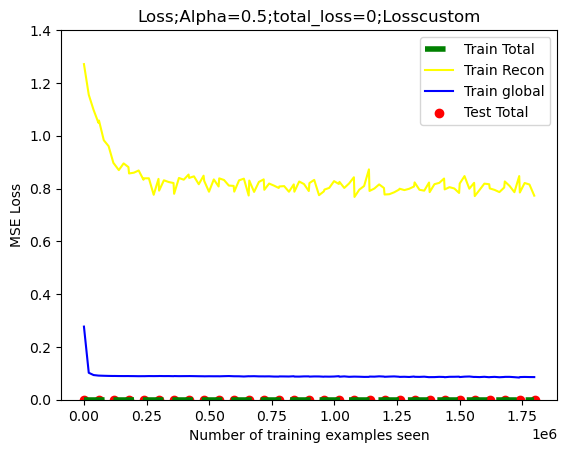

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green', linestyle= 'dashed', linewidth = 4)
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train global', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 1.4])
plt.ylabel('MSE Loss')
plt.title("Loss;Alpha=0.5;total_loss=0;Losscustom")
plt.savefig('./Plots/Metrics/Loss;Alpha=0.5;total_loss=0;Losscustom.png', dpi=300, bbox_inches='tight')
plt.show()

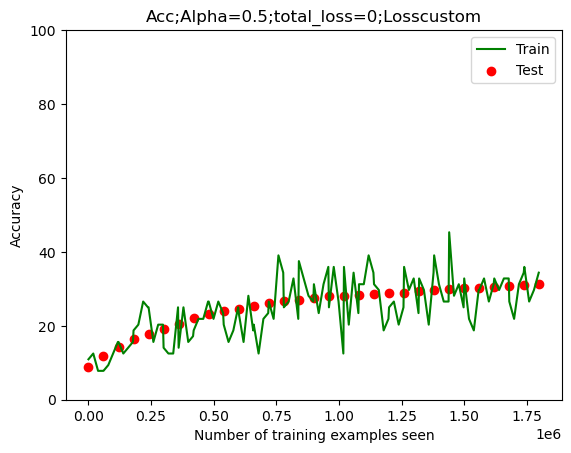

In [8]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_acc, color='green')
plt.scatter(test_counter, test_acc, color='red')
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 100])
plt.ylabel('Accuracy')
plt.title("Acc;Alpha=0.5;total_loss=0;Losscustom")
plt.savefig('./Plots/Metrics/Acc;Alpha=0.5;total_loss=0;Losscustom.png', dpi=300, bbox_inches='tight')
plt.show()

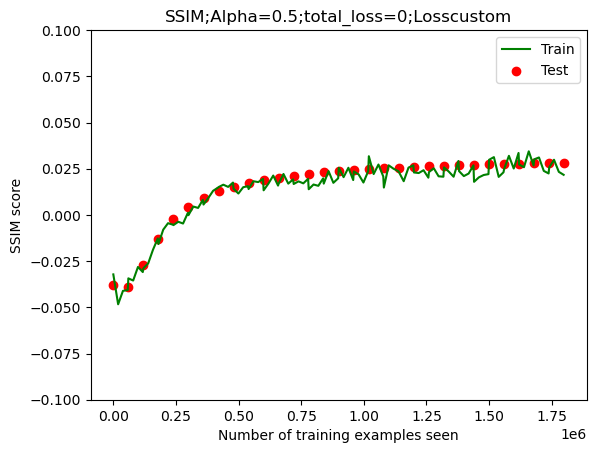

In [9]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_ssim, color='green')
plt.scatter(test_counter, test_ssim, color='red')
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([-0.1, 0.1])
plt.ylabel('SSIM score')
plt.title("SSIM;Alpha=0.5;total_loss=0;Losscustom")
plt.savefig('./Plots/Metrics/SSIM;Alpha=0.5;total_loss=0;Losscustom.png', dpi=300, bbox_inches='tight')
plt.show()
